In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Environment:

    def __init__(self, length = 100, data = []):
        self.length = length
        self.data = data

    def get_state(self, time, lookback, diff = True):
        window = self.data.iloc[time-lookback:time]
        if diff: window = window.diff().fillna(0.0)
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        # 0 => long; 1 => hold, 2 => short
        if action == 0:
            action = 1
        elif action == 1:
            action = 0
        else:
            action = -1
        price_now = self.data.iloc[action_time]
        price_reward = self.data.iloc[reward_time]
        price_diff = (price_reward - price_now) / price_now
        reward = np.sign(price_diff) * action * coef

        return reward.values.tolist()[0]

In [3]:
class Net(nn.Module):
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 10)
        self.fc2 = nn.Linear(10, action_shape)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
class BuyHoldSellAgent:
    def __init__(self, state_shape = 10, action_shape = 3, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.model = Net(state_shape, action_shape)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        self.experience = collections.deque(maxlen=self.experience_size)

    def save_experience(self, state_i, q_value_i, action_i, reward_i, state_i_1):
        self.experience.append({
            'state_i': state_i,
            'q_value_i': q_value_i,
            'action_i': action_i,
            'reward_i': reward_i,
            'state_i_1': state_i_1
        })

    def replay_experience(self, alpha, gamma, sample_size):
        X, Y = [], []
        indices_sampled = np.random.choice(len(self.experience), sample_size, replace=False)
        for i, e in enumerate(self.experience):
            if i in indices_sampled:
                state_i, action_i, reward_i, q_value_i = e['state_i'], e['action_i'], e['reward_i'], e['q_value_i']
                state_i_1 = e['state_i_1']
                q_value_i_1 = self.model(torch.from_numpy(np.expand_dims(state_i_1.values.reshape(1,5), 0)).float())[0]
                y_i = np.zeros(self.action_shape)
                y_i[:] = q_value_i[:].detach()
                y_i[action_i] = (1 - alpha) * y_i[action_i] + alpha * (reward_i + gamma * max(q_value_i_1.detach().numpy()[0]))
                X.append(state_i)
                Y.append(y_i)
                
                outputs = self.model(torch.from_numpy(np.expand_dims(state_i.values.reshape(1,5), 0)).float())[0]
                loss = self.criterion(outputs, torch.Tensor(y_i))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        X, Y = np.array(X), np.array(Y)

    def get_value_action_value(self, state):
        pred = self.model(torch.from_numpy(np.expand_dims(state, 0)).float())
        return pred.flatten()

In [5]:
agent = BuyHoldSellAgent()

# Training

In [18]:
epochs = 5
gamma = 0.9
epsilon = 0.95
alpha = 0.9

In [7]:
DATASET_LENGTH = 250
WINDOW_SHAPE = 5
REWARD_TIME = 1
ACTIONS_SHAPE = 3
SAMPLE_SIZE = 16

In [8]:
df = pd.read_csv('VZ_15_Minutes_(with_indicators)_2018_18012022.txt')
df.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume", "AvgExp", "AvgExp", "vwap_reset", "MACD", "MACDAvg", "MACDDiff", "ZeroLine"]
df

,Date,Time,Open,High,Low,Close,Volume,AvgExp,AvgExp,vwap_reset,MACD,MACDAvg,MACDDiff,ZeroLine
0,02.01.2018,09:45:00,53.160,53.35,52.920,52.960,895725,0.000,0.000,0.000,0.00,0.00,0.00,0.0
1,02.01.2018,10:00:00,52.950,53.16,52.800,53.120,884034,0.000,0.000,0.000,0.00,0.00,0.00,0.0
2,02.01.2018,10:15:00,53.125,53.26,53.035,53.240,435119,0.000,0.000,0.000,0.00,0.00,0.00,0.0
3,02.01.2018,10:30:00,53.240,53.35,53.170,53.340,545240,0.000,0.000,0.000,0.00,0.00,0.00,0.0
4,02.01.2018,10:45:00,53.340,53.48,53.290,53.460,417159,0.000,0.000,0.000,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,18.01.2022,15:00:00,53.470,53.53,53.465,53.530,357171,53.235,53.353,53.448,0.07,0.01,0.06,0.0
26447,18.01.2022,15:15:00,53.520,53.57,53.457,53.485,450275,53.254,53.379,53.460,0.08,0.02,0.06,0.0
26448,18.01.2022,15:30:00,53.485,53.49,53.400,53.425,362992,53.266,53.388,53.459,0.08,0.03,0.05,0.0
26449,18.01.2022,15:45:00,53.436,53.48,53.350,53.385,534119,53.275,53.388,53.451,0.08,0.04,0.04,0.0


In [9]:
df_train = df.Close[:len(df) - 12000].copy(deep=True).reset_index().drop(columns='index')
df_test = df.Close[len(df) - 6000:].copy(deep=True).reset_index().drop(columns='index')
df_val = df.Close[(len(df) - 12000) : len(df) - 6000].copy(deep=True).reset_index().drop(columns='index')

In [21]:
environment = Environment(len(df_train), df_train)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [22]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, len(df_train) - REWARD_TIME, REWARD_TIME): 
        print(f"{i} / {epochs-1} : {j} {len(df_train) - REWARD_TIME}", end='\r')

        # 1. getting current state
        state_j = environment.get_state(j, WINDOW_SHAPE)
        q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))

        # 2. acting in this state
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = (np.argmax(q_value_j.detach()))

        # 3. getting reward from this action
        reward_value_j = environment.get_reward(action, j, j+REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. getting next state and value there
        state_j_1 = environment.get_state(j+1, WINDOW_SHAPE)

        # 5. save this experience
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)

        if j > SAMPLE_SIZE * 2:
            # 6. train on samples from experience
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -0.08307372793354102
Epoch 1 ... 0.5192107995846313
Epoch 2 ... -0.29075804776739356
Epoch 3 ... -0.027691242644513673
Epoch 4 ... 0.4984423676012461


# Evaluation

In [23]:
action_to_backtest_action = {
    0: 1,
    1: 0,
    2: -1
}

In [24]:
# val

environment_val = Environment(len(df_val), df_val)
actions = []
for j in range(WINDOW_SHAPE, len(df_val), REWARD_TIME): 
    state_j = environment_val.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

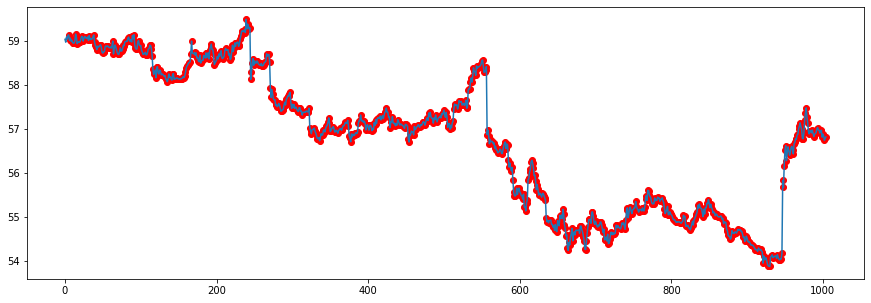

In [25]:
plt.figure(figsize = (15, 5))
data_slice = environment_val.data[-1005:]
data_slice = data_slice.reset_index(drop=True)
plt.plot(data_slice)
for e, a in enumerate(actions[-1000:]):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, data_slice.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, data_slice.iloc[e], color = 'red')
    else:
        pass
plt.show()

<AxesSubplot:>

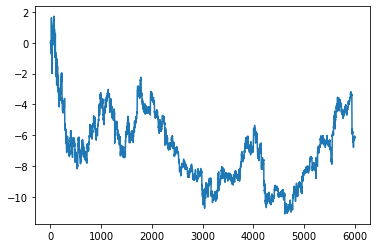

In [26]:
backtest = pd.DataFrame({
    'price': environment_val.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [27]:
# test

environment_test = Environment(len(df_test), df_test)
actions = []
for j in range(WINDOW_SHAPE, len(df_test), REWARD_TIME): 
    state_j = environment_test.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

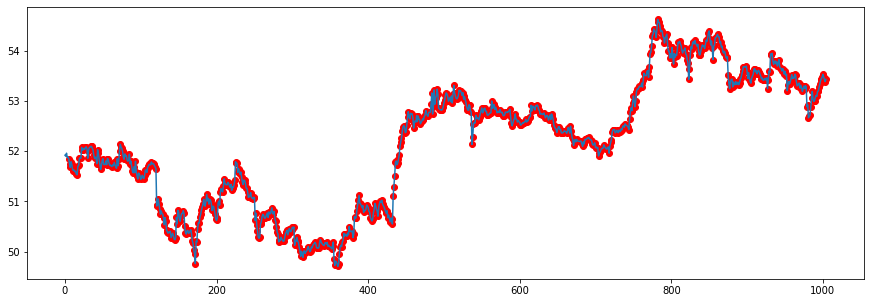

In [28]:
plt.figure(figsize = (15, 5))
data_slice = environment_test.data[-1005:]
data_slice = data_slice.reset_index(drop=True)
plt.plot(data_slice)
for e, a in enumerate(actions[-1000:]):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, data_slice.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, data_slice.iloc[e], color = 'red')
    else:
        pass
plt.show()

<AxesSubplot:>

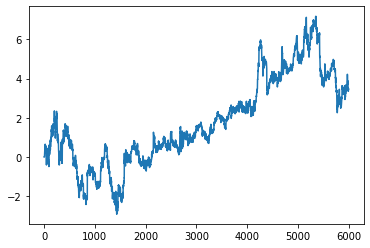

In [29]:
backtest = pd.DataFrame({
    'price': environment_test.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [30]:
# Еще поучим 5 эпох

for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, len(df_train) - REWARD_TIME, REWARD_TIME): 
        print(f"{i} / {epochs-1} : {j} {len(df_train) - REWARD_TIME}", end='\r')

        # 1. getting current state
        state_j = environment.get_state(j, WINDOW_SHAPE)
        q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))

        # 2. acting in this state
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = (np.argmax(q_value_j.detach()))

        # 3. getting reward from this action
        reward_value_j = environment.get_reward(action, j, j+REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. getting next state and value there
        state_j_1 = environment.get_state(j+1, WINDOW_SHAPE)

        # 5. save this experience
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)

        if j > SAMPLE_SIZE * 2:
            # 6. train on samples from experience
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

C:\Users\PiviN\anaconda3\envs\nn_gpu\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 ... 0.6645898234683282
Epoch 1 ... -0.04153686396677051
Epoch 2 ... 0.04153686396677051
Epoch 3 ... 0.06922810661128419
Epoch 4 ... 0.04153686396677051


In [31]:
# val

environment_val = Environment(len(df_val), df_val)
actions = []
for j in range(WINDOW_SHAPE, len(df_val), REWARD_TIME): 
    state_j = environment_val.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

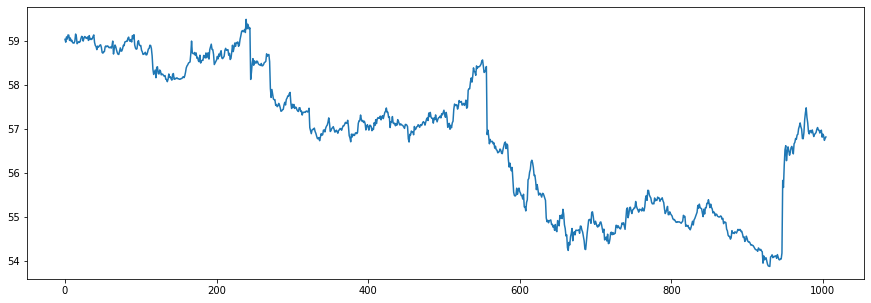

In [32]:
plt.figure(figsize = (15, 5))
data_slice = environment_val.data[-1005:]
data_slice = data_slice.reset_index(drop=True)
plt.plot(data_slice)
for e, a in enumerate(actions[-1000:]):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, data_slice.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, data_slice.iloc[e], color = 'red')
    else:
        pass
plt.show()

<AxesSubplot:>

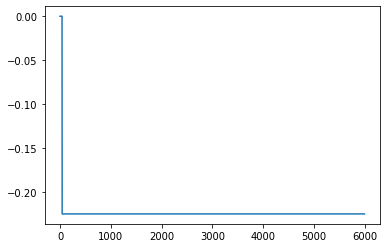

In [33]:
backtest = pd.DataFrame({
    'price': environment_val.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [34]:
# test

environment_test = Environment(len(df_test), df_test)
actions = []
for j in range(WINDOW_SHAPE, len(df_test), REWARD_TIME): 
    state_j = environment_test.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j.values.reshape(1,5))
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

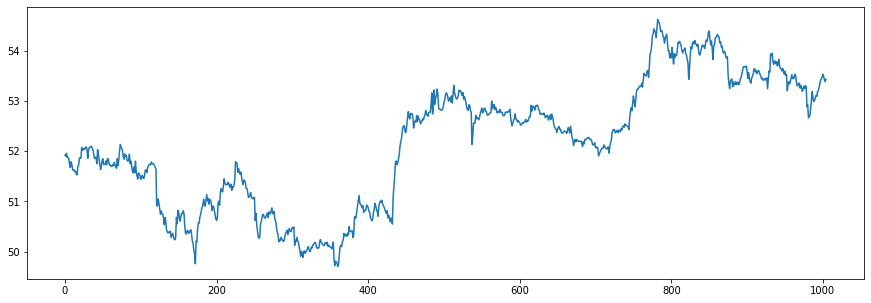

In [35]:
plt.figure(figsize = (15, 5))
data_slice = environment_test.data[-1005:]
data_slice = data_slice.reset_index(drop=True)
plt.plot(data_slice)
for e, a in enumerate(actions[-1000:]):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, data_slice.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, data_slice.iloc[e], color = 'red')
    else:
        pass
plt.show()

<AxesSubplot:>

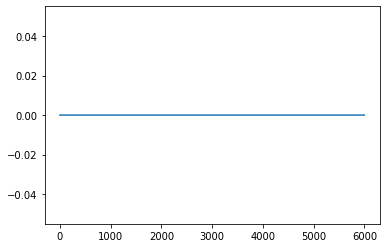

In [36]:
backtest = pd.DataFrame({
    'price': environment_test.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()